In [3]:
import os
import importlib as imp
import pandas as pd
import keras_tuner as kt
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

from Script import path_handler as ph
from Script import data_processing as dp
from Script import models

In [12]:
imp.reload(ph)
imp.reload(dp)
imp.reload(models)

<module 'Script.models' from 'c:\\Users\\User\\Desktop\\Jupyter\\TA\\FlutterStabilityClassification\\Script\\models.py'>

In [5]:
data = dp.scan()
label = data[:,2]
input = data[:,:2]
X_train, X_val, y_train, y_val = dp.train_val_split(input, label)

In [4]:
max_epoch= 100
callbacks = [
        EarlyStopping(
            monitor='val_Accuracy',
            min_delta=1e-5,
            patience=30,
            verbose=1,
            mode='max',
            restore_best_weights= True
        )]
def confusion_matrix(labels, predictions):
    return tf.math.confusion_matrix(labels,predictions)

In [6]:
tf.keras.backend.clear_session()
model1 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(100, activation='relu', input_dim= 2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='binary_crossentropy', optimizer='adam',metrics=['Accuracy'])

history1 = model1.fit(X_train,y_train, epochs= max_epoch,callbacks=callbacks,
                validation_data=(X_val, y_val),verbose=1)

Epoch 1/100
6/6 [==============================] - 2s 89ms/step - loss: 0.6720 - Accuracy: 0.7349 - val_loss: 0.6566 - val_Accuracy: 0.8194
Epoch 2/100
6/6 [==============================] - 0s 18ms/step - loss: 0.6614 - Accuracy: 0.6988 - val_loss: 0.6456 - val_Accuracy: 0.8194
Epoch 3/100
6/6 [==============================] - 0s 18ms/step - loss: 0.6539 - Accuracy: 0.7048 - val_loss: 0.6351 - val_Accuracy: 0.7917
Epoch 4/100
6/6 [==============================] - 0s 19ms/step - loss: 0.6458 - Accuracy: 0.6807 - val_loss: 0.6264 - val_Accuracy: 0.7083
Epoch 5/100
6/6 [==============================] - 0s 22ms/step - loss: 0.6398 - Accuracy: 0.6807 - val_loss: 0.6184 - val_Accuracy: 0.7361
Epoch 6/100
6/6 [==============================] - 0s 19ms/step - loss: 0.6346 - Accuracy: 0.6747 - val_loss: 0.6109 - val_Accuracy: 0.7361
Epoch 7/100
6/6 [==============================] - 0s 22ms/step - loss: 0.6287 - Accuracy: 0.6747 - val_loss: 0.6036 - val_Accuracy: 0.7361
Epoch 8/100
6/6 [===

In [8]:
model1.evaluate(X_train, y_train)

6/6 [==============================] - 0s 4ms/step - loss: 0.5463 - Accuracy: 0.7410


[0.5462666153907776, 0.740963876247406]

In [9]:
model1.evaluate(X_val, y_val)

3/3 [==============================] - 0s 5ms/step - loss: 0.4972 - Accuracy: 0.8472


[0.49722278118133545, 0.8472222089767456]

In [10]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               300       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [26]:
predict = model1.predict(X_val)

3/3 [==============================] - 0s 4ms/step


In [27]:
confs = confusion_matrix(y_val, predict)
confs

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[51,  0],
       [21,  0]])>

In [22]:
predict = model1.predict(X_train)
pred = np.round(predict)

6/6 [==============================] - 0s 4ms/step


In [61]:
pred

0.0

In [23]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
confusion_mat= confusion_matrix(y_train, pred)
tn, fp, fn, tp=confusion_mat.ravel()
print(tn, fp, fn, tp)

82 18 25 41


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

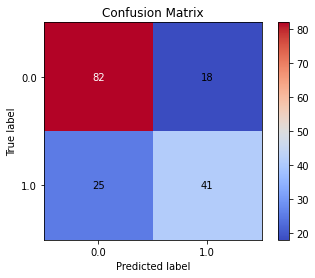

In [25]:
skplt.metrics.plot_confusion_matrix(y_train, pred,cmap= 'coolwarm')

In [12]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
confusion_mat= confusion_matrix(y_val, pred)
tn, fp, fn, tp=confusion_mat.ravel()
print(tn, fp, fn, tp)

42 4 7 19


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

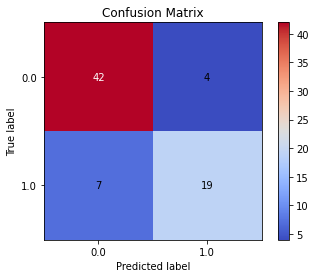

In [13]:
skplt.metrics.plot_confusion_matrix(y_val, pred,cmap= 'coolwarm')

Text(0, 0.5, 'Validation Accuracy')

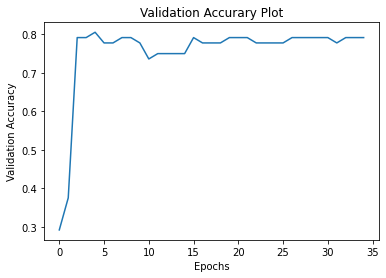

In [32]:
plt.plot(history1.history['val_Accuracy'])
plt.title('Validation Accurary Plot')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

Text(0, 0.5, 'Accuracy')

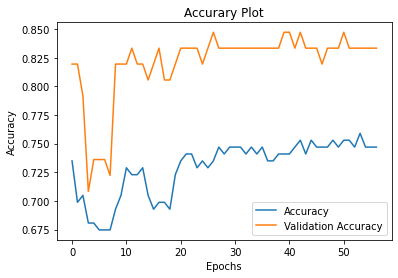

In [14]:
plt.plot(history1.history['Accuracy'],label='Accuracy')
plt.plot(history1.history['val_Accuracy'],label='Validation Accuracy')
plt.title('Accurary Plot')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

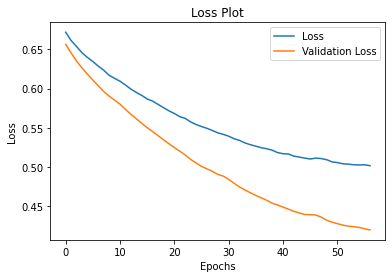

In [15]:
plt.plot(history1.history['loss'],label='Loss')
plt.plot(history1.history['val_loss'],label='Validation Loss')
plt.title('Loss Plot')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [74]:
def build_model(hp):
      model = tf.keras.models.Sequential([
          tf.keras.Input(shape=(None,2)),
      ])
      
      # Tune the number of layers.
      for i in range(hp.Int("num_layers", 1, 5)):
          model.add(
              tf.keras.layers.Dense(
                  # Tune number of units separately.
                  units=hp.Int(f"units_{i}", min_value=10, max_value=200, step=5),
                  activation= 'relu' # hp.Choice("activation", ["relu", "tanh"]),
              )
          )


      # Output Layer
      model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

      # Code to train and compile the model
      optimizer = tf.keras.optimizers.Adam() # YOUR CODE HERE
      model.compile(
          # YOUR CODE HERE
          optimizer=optimizer,
          metrics=['Accuracy'],
          loss='binary_crossentropy'
      )

      return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_Accuracy',
    max_trials=100)  

tuner.search(X_train,y_train, validation_data=(X_val,y_val), epochs=5)
best_model = tuner.get_best_models()[0]  

Trial 100 Complete [00h 00m 09s]
val_Accuracy: 0.7916666865348816

Best val_Accuracy So Far: 0.8194444179534912
Total elapsed time: 00h 15m 00s
INFO:tensorflow:Oracle triggered exit


In [75]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 234)         702       
                                                                 
 dense_1 (Dense)             (None, None, 42)          9870      
                                                                 
 dense_2 (Dense)             (None, None, 394)         16942     
                                                                 
 dense_3 (Dense)             (None, None, 1)           395       
                                                                 
Total params: 27,909
Trainable params: 27,909
Non-trainable params: 0
_________________________________________________________________


In [83]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(50, activation='relu', input_dim= 2),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['Accuracy'])

history = model.fit(X_train,y_train, epochs= max_epoch, callbacks=callbacks,
                validation_data=(X_val, y_val),verbose=1)

Epoch 1/300
6/6 [==============================] - 3s 139ms/step - loss: 0.6772 - Accuracy: 0.6024 - val_loss: 0.6538 - val_Accuracy: 0.7778
Epoch 2/300
6/6 [==============================] - 0s 37ms/step - loss: 0.6493 - Accuracy: 0.7651 - val_loss: 0.6281 - val_Accuracy: 0.7778
Epoch 3/300
6/6 [==============================] - 0s 31ms/step - loss: 0.6273 - Accuracy: 0.7771 - val_loss: 0.6083 - val_Accuracy: 0.7917
Epoch 4/300
6/6 [==============================] - 0s 24ms/step - loss: 0.6091 - Accuracy: 0.7651 - val_loss: 0.5833 - val_Accuracy: 0.7778
Epoch 5/300
6/6 [==============================] - 0s 26ms/step - loss: 0.5931 - Accuracy: 0.7590 - val_loss: 0.5617 - val_Accuracy: 0.7917
Epoch 6/300
6/6 [==============================] - 0s 25ms/step - loss: 0.5700 - Accuracy: 0.7590 - val_loss: 0.5360 - val_Accuracy: 0.7639
Epoch 7/300
6/6 [==============================] - 0s 28ms/step - loss: 0.5485 - Accuracy: 0.7590 - val_loss: 0.5149 - val_Accuracy: 0.7639
Epoch 8/300
6/6 [==

In [12]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        """Builds a convolutional model."""
        inputs = tf.keras.Input(shape=(None, 2))
        for i in range(hp.Int("num_layers", 1, 5)):
              x = tf.keras.layers.Dense(
                  # Tune number of units separately.
                  units=hp.Int(f"units_{i}", min_value=10, max_value=200, step=5),
                  activation= 'relu' # hp.Choice("activation", ["relu", "tanh"]),
              )(inputs)
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        return tf.keras.Model(inputs=inputs, outputs=outputs)

    def fit(self, hp, model, x, y, validation_data, callbacks=None, **kwargs):
        # Convert the datasets to tf.data.Dataset.
        batch_size = hp.Int("batch_size", 32, 128, step=32, default=64)
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(
            batch_size
        )
        validation_data = tf.data.Dataset.from_tensor_slices(validation_data).batch(
            batch_size
        )

        # Define the optimizer.
        optimizer = tf.keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3)
        )
        loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # The metric to track validation loss.
        epoch_loss_metric = tf.keras.metrics.Mean()

        # Function to run the train step.
        @tf.function
        def run_train_step(X_train, y_train):
            with tf.GradientTape() as tape:
                logits = model(X_train)
                loss = loss_fn(y_train, logits)
                # Add any regularization losses.
                if model.losses:
                    loss += tf.math.add_n(model.losses)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Function to run the validation step.
        @tf.function
        def run_val_step(X_train, y_train):
            logits = model(X_train)
            loss = loss_fn(y_train, logits)
            # Update the metric.
            epoch_loss_metric.update_state(loss)

        # Assign the model to the callbacks.
        for callback in callbacks:
            callback.model = model

        # Record the best validation loss value
        best_epoch_loss = float("inf")

        # The custom training loop.
        for epoch in range(5):
            print(f"Epoch: {epoch}")

            # Iterate the training data to run the training step.
            for X_train, y_train in train_ds:
                run_train_step(X_train, y_train)

            # Iterate the validation data to run the validation step.
            for X_val, y_val in validation_data:
                run_val_step(X_val, y_val)

            # Calling the callbacks after epoch.
            epoch_loss = float(epoch_loss_metric.result().numpy())
            for callback in callbacks:
                # The "my_metric" is the objective passed to the tuner.
                callback.on_epoch_end(epoch, logs={"my_metric": epoch_loss})
            epoch_loss_metric.reset_states()

            print(f"Epoch loss: {epoch_loss}")
            best_epoch_loss = min(best_epoch_loss, epoch_loss)

        # Return the evaluation metric value.
        return best_epoch_loss

In [13]:
tuner = kt.RandomSearch(
    objective=kt.Objective("my_metric", "min"),
    max_trials=200,
    hypermodel=MyHyperModel(),
    directory="results",
    project_name="custom_training",
    overwrite=True,
)

In [14]:
tuner.search(x=X_train, y=y_train, validation_data=(X_val, y_val))

Trial 200 Complete [00h 00m 03s]
my_metric: 0.8241209387779236

Best my_metric So Far: 0.6984691619873047
Total elapsed time: 00h 14m 58s
INFO:tensorflow:Oracle triggered exit


In [15]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

best_model = tuner.get_best_models()[0]
best_model.summary()

{'num_layers': 4, 'units_0': 40, 'units_1': 115, 'units_2': 125, 'units_3': 120, 'batch_size': 64, 'learning_rate': 0.00823459375519691, 'units_4': 30}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 2)]         0         
                                                                 
 dense_3 (Dense)             (None, None, 120)         360       
                                                                 
 dense_4 (Dense)             (None, None, 1)           121       
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [22]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(115, activation='relu', input_dim= 2),
        tf.keras.layers.Dense(125, activation='relu'),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00823459375519691)
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['Accuracy'])

history = model.fit(X_train,y_train, epochs= max_epoch, callbacks=callbacks,
                validation_data=(X_val, y_val),verbose=1, batch_size=64)

Epoch 1/100
3/3 [==============================] - 2s 397ms/step - loss: 0.6812 - Accuracy: 0.6325 - val_loss: 0.6771 - val_Accuracy: 0.6944
Epoch 2/100
3/3 [==============================] - 0s 58ms/step - loss: 0.6624 - Accuracy: 0.7349 - val_loss: 0.6580 - val_Accuracy: 0.7778
Epoch 3/100
3/3 [==============================] - 0s 43ms/step - loss: 0.6468 - Accuracy: 0.7711 - val_loss: 0.6360 - val_Accuracy: 0.7778
Epoch 4/100
3/3 [==============================] - 0s 46ms/step - loss: 0.6325 - Accuracy: 0.7711 - val_loss: 0.6255 - val_Accuracy: 0.7500
Epoch 5/100
3/3 [==============================] - 0s 50ms/step - loss: 0.6145 - Accuracy: 0.7831 - val_loss: 0.6094 - val_Accuracy: 0.7500
Epoch 6/100
3/3 [==============================] - 0s 47ms/step - loss: 0.5981 - Accuracy: 0.7771 - val_loss: 0.5915 - val_Accuracy: 0.7500
Epoch 7/100
3/3 [==============================] - 0s 48ms/step - loss: 0.5803 - Accuracy: 0.7771 - val_loss: 0.5692 - val_Accuracy: 0.7639
Epoch 8/100
3/3 [==

In [23]:
model.evaluate(X_val, y_val)

3/3 [==============================] - 0s 4ms/step - loss: 0.4880 - Accuracy: 0.8056


[0.48802533745765686, 0.8055555820465088]

In [17]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation='relu', input_dim = 2),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['Accuracy'])

history = model.fit(X_train,y_train, epochs= max_epoch, 
                    validation_data=(X_val, y_val),verbose=1, callbacks=callbacks)

Epoch 1/100
6/6 [==============================] - 2s 112ms/step - loss: 0.6861 - Accuracy: 0.6084 - val_loss: 0.6594 - val_Accuracy: 0.7917
Epoch 2/100
6/6 [==============================] - 0s 20ms/step - loss: 0.6578 - Accuracy: 0.7169 - val_loss: 0.6240 - val_Accuracy: 0.8333
Epoch 3/100
6/6 [==============================] - 0s 25ms/step - loss: 0.6318 - Accuracy: 0.7349 - val_loss: 0.5826 - val_Accuracy: 0.8333
Epoch 4/100
6/6 [==============================] - 0s 27ms/step - loss: 0.6004 - Accuracy: 0.7349 - val_loss: 0.5459 - val_Accuracy: 0.8194
Epoch 5/100
6/6 [==============================] - 0s 22ms/step - loss: 0.5726 - Accuracy: 0.7349 - val_loss: 0.5009 - val_Accuracy: 0.8194
Epoch 6/100
6/6 [==============================] - 0s 27ms/step - loss: 0.5558 - Accuracy: 0.7711 - val_loss: 0.4702 - val_Accuracy: 0.8194
Epoch 7/100
6/6 [==============================] - 0s 27ms/step - loss: 0.5313 - Accuracy: 0.7289 - val_loss: 0.4497 - val_Accuracy: 0.8056
Epoch 8/100
6/6 [==

In [18]:
model.evaluate(X_val,y_val)

3/3 [==============================] - 0s 5ms/step - loss: 0.3870 - Accuracy: 0.8472


[0.387026309967041, 0.8472222089767456]

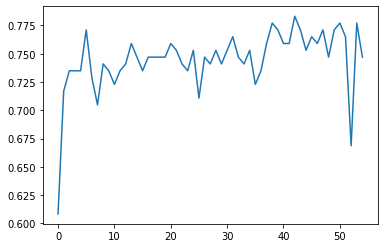

In [21]:
plt.plot(history.history['Accuracy'])